In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def regloss(y_pred,y,w1,w2=0):
    batch_size=y_pred.shape[0]
    K=y_pred.shape[1]
    loss=(1/(batch_size))*(np.square(y-y_pred)).sum()+reg*(np.sum(w1*w1)+np.sum(w2*w2))
    return loss

In [3]:
def accuracy(y_pred,y):
    batch_size=y_pred.shape[0]
    K=y_pred.shape[1]
    acc=1-(1/(batch_size*K))*(np.abs(np.argmax(y,axis=1)-np.argmax(y_pred,axis=1))).sum()
    return acc

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

K = len(np.unique(y_train)) # Classes #np.unique Find the unique elements of an array.
Ntr = x_train.shape[0]
Nte = x_test.shape[0]
Din = x_train.shape[1]*x_train.shape[2]*x_train.shape[3] # CIFAR10

# Normalize pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0
mean_image = np.mean(x_train, axis=0)
x_train = x_train - mean_image
x_test = x_test - mean_image

y_train = tf.keras.utils.to_categorical(y_train, num_classes=K)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K)

x_train = np.reshape(x_train,(Ntr,Din))
x_test = np.reshape(x_test,(Nte,Din))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

x_train: (50000, 3072)
x_test: (10000, 3072)
y_train: (50000, 10)
y_test: (10000, 10)


# Linear Classifier

In [9]:
def linclas(x_train,y_train,x_test,y_test,K,Din,lr,lr_decay,reg):
    Ntr = x_train.shape[0]
    Nte = x_test.shape[0]

    loss_history = []
    train_acc_history = []
    val_acc_history = []
    seed = 0
    rng = np.random.default_rng(seed=seed)

    std=1e-5
    w1 = std*np.random.randn(Din, K)
    b1 = np.zeros(K)

    for t in range(iterations):
        indices = np.arange(Ntr)
        rng.shuffle(indices)
        x=x_train[indices]
        y=y_train[indices]

        #forward pass
        y_pred=x.dot(w1)+b1
        y_pred_test=x_test.dot(w1)+b1
        train_loss=regloss(y_pred,y,w1)
        test_loss=regloss(y_pred_test,y_test,w1)
        #loss=(1/batch_size)*np.sum(np.square(y_train-y_pred),axis=0)+reg*np.sum(w1*w1)
        loss_history.append(train_loss)
        
        train_acc=accuracy(y_pred,y)
        train_acc_history.append(train_acc)
        test_acc=accuracy(y_pred_test,y_test)
        val_acc_history.append(test_acc)

        if t%10 == 0:
            print('epoch %d/%d: MSloss= %f-- ,test loss= %f--,train accracy= %f--, test accracy= %f' % (t,iterations,train_loss,test_loss,train_acc,test_acc))

        # Backward pass
        dy_pred=(1./batch_size)*2.0*(y_pred-y)
        dw1=x.T.dot(dy_pred)+reg*w1
        db1=dy_pred.sum(axis=0)
        w1-=lr*dw1
        b1-=lr*db1
        lr*=lr_decay
    return w1,b1,loss_history,train_acc_history,val_acc_history

In [12]:
batch_size = Ntr
iterations = 300
lr = 1.4e-2
lr_decay= 0.999
reg = 5e-6 #lamda
w1,b1,loss_history,train_acc_history,val_acc_history=linclas(x_train,y_train,x_test,y_test,K,Din,lr,lr_decay,reg)

epoch 0/300: MSloss= 0.999996-- ,test loss= 0.999996--,train accracy= 0.676476--, test accracy= 0.677610
epoch 10/300: MSloss= 0.876633-- ,test loss= 0.876233--,train accracy= 0.756502--, test accracy= 0.758120
epoch 20/300: MSloss= 0.842538-- ,test loss= 0.842415--,train accracy= 0.762610--, test accracy= 0.767630
epoch 30/300: MSloss= 0.823614-- ,test loss= 0.823713--,train accracy= 0.766438--, test accracy= 0.770600
epoch 40/300: MSloss= 0.812387-- ,test loss= 0.812706--,train accracy= 0.768626--, test accracy= 0.771580
epoch 50/300: MSloss= 0.805425-- ,test loss= 0.805969--,train accracy= 0.770338--, test accracy= 0.772900
epoch 60/300: MSloss= 0.800904-- ,test loss= 0.801678--,train accracy= 0.771564--, test accracy= 0.773290
epoch 70/300: MSloss= 0.797820-- ,test loss= 0.798823--,train accracy= 0.772736--, test accracy= 0.773690
epoch 80/300: MSloss= 0.795604-- ,test loss= 0.796833--,train accracy= 0.773762--, test accracy= 0.774240
epoch 90/300: MSloss= 0.793929-- ,test loss= 0.

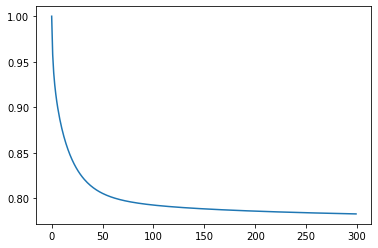

In [13]:
x_axis=np.arange(len(loss_history))
plt.plot(x_axis,loss_history)

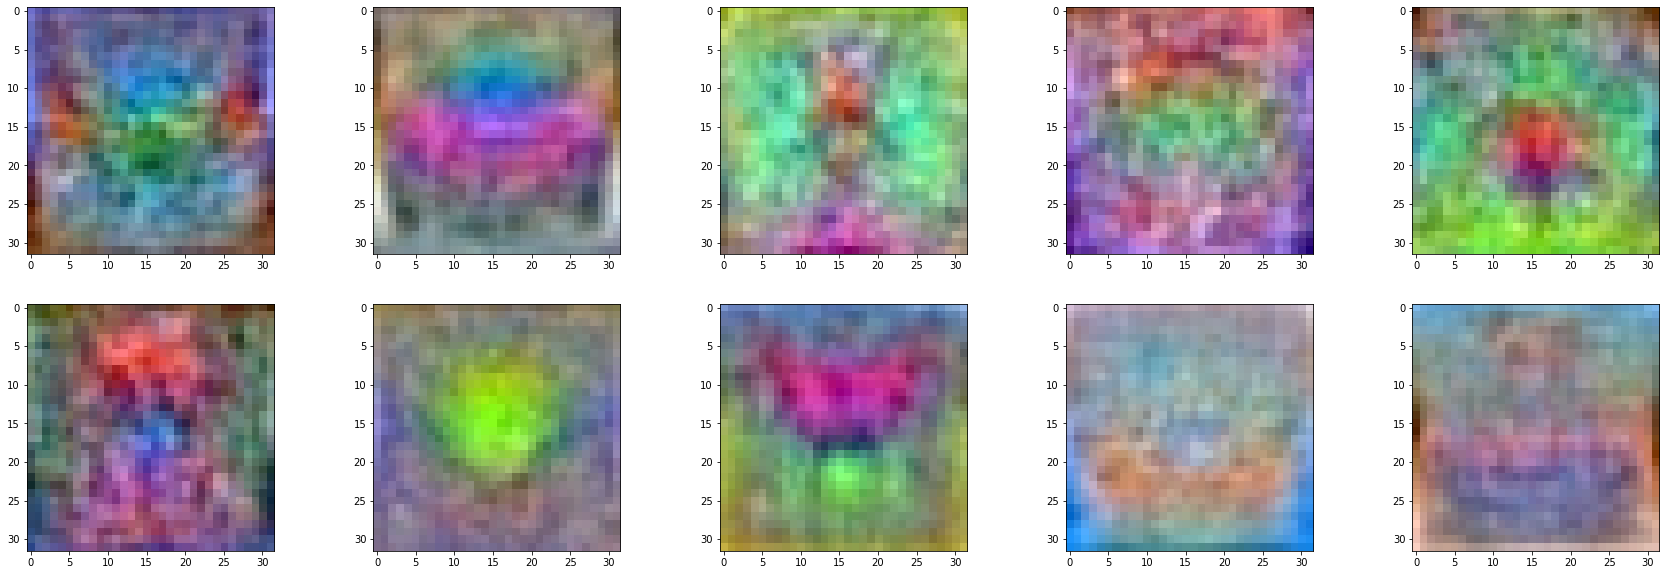

In [14]:
import cv2 as cv
images=[]
for i in range(w1.shape[1]):
    temp=np.reshape(w1[:,i]*255,(32,32,3))
    temp=cv.normalize(temp, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    images.append(temp)
fig,ax=plt.subplots(2,5,figsize=(30,10))
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(images[i*5+j],vmin=0,vmax=255)
plt.show()

# 2 Layer Dense Network

In [15]:
def linclas(x_train,y_train,x_test,y_test,batch_size,H,K,Din,lr,lr_decay,reg):
    Ntr = x_train.shape[0]
    Nte = x_test.shape[0]

    loss_history = []
    train_acc_history = []
    val_acc_history = []
    seed = 0
    rng = np.random.default_rng(seed=seed)

    std=1e-5
    w1 = (2/(Ntr*Din))**0.5*np.random.randn(Din, H)
    w2 = (2/(H*Din))**0.5*np.random.randn(H, K)
    b1 = np.zeros(H)
    b2 = np.zeros(K)

    for t in range(iterations):
        indices = np.random.choice(Ntr,batch_size)
        rng.shuffle(indices)
        x=x_train[indices]*255
        y=y_train[indices]

        #forward pass
        h=1/(1+np.exp(-(x.dot(w1)+b1)))
        h_test=1/(1+np.exp(-((x_test*255).dot(w1)+b1)))

        y_pred=h.dot(w2)+b2
        y_pred_test=h_test.dot(w2)+b2


        train_loss=regloss(y_pred,y,w1,w2)
        test_loss=regloss(y_pred_test,y_test,w1,w2)
        #loss=(1/batch_size)*np.sum(np.square(y_train-y_pred),axis=0)+reg*np.sum(w1*w1)
        loss_history.append(train_loss)
        
        train_acc=accuracy(y_pred,y)
        train_acc_history.append(train_acc)
        test_acc=accuracy(y_pred_test,y_test)
        val_acc_history.append(test_acc)

        if t%10 == 0:
            print('epoch %d/%d: MSloss= %f-- ,test loss= %f--,train accracy= %f--, test accracy= %f' % (t,iterations,train_loss,test_loss,train_acc,test_acc))

        # Backward pass
        dy_pred=(1./batch_size)*2.0*(y_pred-y)
        dw2=h.T.dot(dy_pred)+reg*w2
        db2=dy_pred.sum(axis=0)
        dh=dy_pred.dot(w2.T)
        dw1=x.T.dot(dh*h*(1-h))+reg*w1
        db1=(dh*h*(1-h)).sum(axis=0)
        w1-=lr*dw1
        b1-=lr*db1
        w2-=lr*dw2
        b2-=lr*db2
        lr*=lr_decay
    return w1,b1,w2,b2,loss_history,train_acc_history,val_acc_history